# Azimuthal Symmetry

**Goal:** Let's try to understand if pairAGraph has *learned* about azimuthal symmetry or not.

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob
import uproot
import json
import matplotlib.pyplot as plt

import math

import networkx as nx
import torch
from torch import nn
import torch.nn.functional as F
from itertools import combinations

from preprocess import getNumPairs, scale, transformData, prepareData,jetVars
from trainNet import getGNNDataLoaders, pairAGraph, basicAttn,  check_accuracy, train

import os
os.sys.path.append('../code')
from analysis import normalizeWeight
from eventDisplays import truthDisplay

%load_ext autoreload
%autoreload 2

In [4]:
physicsSample = 'SMNR'
nSelectedJets = 5
prodTag = 'MAR2020'

In [7]:
model = basicAttn(inpt_dim=len(jetVars))

# Load in model trained in Attention nb
subDir = f"{physicsSample}_mc16ade_PFlow-{prodTag}-{nSelectedJets}jets"

# Use the parameters of the model to load in model name
embed_dim = 20
nHeads, nLayers = 4, 1
scoreFct = 'jetCompatibility'
lr, batch_size = .01, 2048

specs = f"attn_latent_1block_dim{embed_dim}_{nHeads}heads_{scoreFct}_lr{lr}_batch{batch_size}_mask"
modelDir = f"models/{subDir}/{specs}/"
model.load_state_dict(torch.load(f'{modelDir}/model.pt',map_location='cpu'))
model.eval()

basicAttn(
  (toLatent): Linear(in_features=5, out_features=20, bias=True)
  (attnLayer): MultiheadAttention(
    (out_proj): Linear(in_features=20, out_features=20, bias=True)
  )
)

**Load in the data**

In [14]:
mc = 'mc16a'
subDir = f'{physicsSample}_{mc}_PFlow-{prodTag}-{nSelectedJets}jets'

df = pd.read_hdf(f"../data/{subDir}/df_3b_scaledInputs.h5", key='df')
df = df[df.index % 2 == 0]

In [9]:
df.head()

eventNumber  nresolvedJets  resolved_nBTags  mcEventWeight  \
entry                                                               
0              442              4                3       0.120290   
2             1088              6                4       0.037104   
14            1974              6                3       0.116338   
22            1823              6                3       0.083696   
24            1931              7                3      -0.085212   

       weight_pileup  rand_run_nr       j0_pt    j0_eta    j0_phi        j0_E  \
entry                                                                           
0           0.832972       310863   65.844810  0.146446  2.467891   67.811531   
2           0.913518       307619  141.734589 -1.114459  0.415969  240.037628   
14          1.124388       303421   95.889526 -1.953326  2.524543  345.063019   
22          0.913518       311321  332.366669  0.302779  1.854437  348.910309   
24          0.874238       304198  209.542023 -0.134799 -1.734556  213.012665   

       ...   ml_j0_E   ml_j1_E   ml_j2_E   ml_j3_E   ml_j4_E  ml_j0_Db  \
entry  ...                                                               
0      ... -1.545873 -0.162072  0.601737 -1.516668  0.000000       2.0   
2      ...  0.353616 -0.495451  0.014767 -0.726483 -0.459885       2.0   
14     ...  0.759894 -0.034947 -0.786970 -1.846490 -2.769203      -2.0   
22     ...  0.771959  1.068133  0.777277 -0.184197 -3.831942      -2.0   
24     ...  0.213887  0.568335  0.242378 -1.113476 -2.045669      -1.0   

       ml_j1_Db  ml_j2_Db  ml_j3_Db  ml_j4_Db  
entry                                          
0          -2.0       2.0       2.0       0.0  
2           2.0       2.0      -2.0       2.0  
14          2.0       2.0       2.0      -2.0  
22          2.0      -2.0       2.0       1.0  
24         -2.0       2.0       2.0       2.0  

[5 rows x 117 columns]

In [24]:
# for c in df.columns:
#     print(c)

Ok - I saw below how to *demonstrate* the effect that I was trying to probe, but the pairing decision *never changed*, so I think I'm going to need to zoom in on a harder problem...

In [200]:
df.loc[(df.truth_mhh < 300)&(df.correctPair!=-1)&df.trigger&(df.ntag>=4),['truth_mhh','ntag','njets']]

truth_mhh  ntag  njets
entry                          
7304    264.483337     4      4
10412   290.008270     4      4
57680   285.792999     4      5
77820   295.744171     4      4
85878   281.431305     4      4
...            ...   ...    ...
724280  291.296448     4      5
729800  285.803680     4      5
759310  273.251587     4      4
761662  284.590179     4      5
765034  292.903137     4      4

[76 rows x 3 columns]

Event 3076 seems like a promising candidate with 4bs and 5 jets and a truth $m_{hh} = 285$ GeV.

In [201]:
evt = 57680
K = 16

jcols = [f'j{i}_{v}' for i in range(nSelectedJets) for v in ['pt','eta','phi','Db']]

X = df.loc[evt,jcols].values.reshape(1,-1) * np.ones((K,1))
X.shape

dfi = pd.DataFrame(X,index=range(16),columns=jcols)

# Add extra cols needed for the event display
cols = ['mcEventWeight','truth_mhh','trigger']
cols += [f'h{i}_{v}' for i in range(2) for v in ['pt','eta','phi','barcode']]
cols += [f'b{i}_{v}' for i in range(4) for v in ['pt','eta','phi','parent_barcode']]

for c in cols:
    dfi[c] = df.loc[evt,c]


'''
And now do the rotation
'''
jphis = [f'j{i}_phi' for i in range(nSelectedJets)]
bphis = [f'b{i}_phi' for i in range(4)]
hphis = [f'h{i}_phi' for i in range(2)]

for ki in range(1,K):
    for phi_cols in [jphis, bphis, hphis]:
        x = dfi.loc[ki,phi_cols] + 2 * ki * np.pi / K
        x = np.where(x>np.pi, x-2*np.pi, x)
        x = np.where(x<-np.pi, x+2*np.pi, x)

        dfi.loc[ki,phi_cols] = x
    
dfi.head()

j0_pt   j0_eta    j0_phi j0_Db    j1_pt    j1_eta   j1_phi j1_Db  \
0  275.298  2.34049  -1.07014     1  99.9868  0.830066  2.04786     5   
1  275.298  2.34049 -0.677437     1  99.9868  0.830066  2.44056     5   
2  275.298  2.34049 -0.284738     1  99.9868  0.830066  2.83325     5   
3  275.298  2.34049  0.107962     1  99.9868  0.830066 -3.05723     5   
4  275.298  2.34049  0.500661     1  99.9868  0.830066 -2.66453     5   

     j2_pt    j2_eta  ...    b1_phi b1_parent_barcode     b2_pt    b2_eta  \
0  82.8582  0.669806  ...  0.779759             10059  73.26741  1.450709   
1  82.8582  0.669806  ...  1.172458             10059  73.26741  1.450709   
2  82.8582  0.669806  ...  1.565157             10059  73.26741  1.450709   
3  82.8582  0.669806  ...  1.957856             10059  73.26741  1.450709   
4  82.8582  0.669806  ...  2.350555             10059  73.26741  1.450709   

     b2_phi b2_parent_barcode      b3_pt    b3_eta    b3_phi b3_parent_barcode  
0 -3.117703             10060  67.125992  0.351102  1.682795             10060  
1 -2.725004             10060  67.125992  0.351102  2.075494             10060  
2 -2.332305             10060  67.125992  0.351102  2.468193             10060  
3 -1.939606             10060  67.125992  0.351102  2.860892             10060  
4 -1.546907             10060  67.125992  0.351102 -3.029594             10060  

[5 rows x 47 columns]

In [202]:
subDir

'SMNR_mc16a_PFlow-MAR2020-5jets'

In [203]:
figDir = f'figures/{subDir}/{specs}/eventDisplays/event{evt}_rotate'
if not os.path.exists(figDir):
    os.mkdir(figDir)

In [204]:
fourbText = "$\mathbf{ATLAS}$ Simulation Internal\n"
fourbText += f"SM NR mc16a MAR 2020 MNT\n"
fourbText += "2016 triggers, 4b DL1r 77% WP"

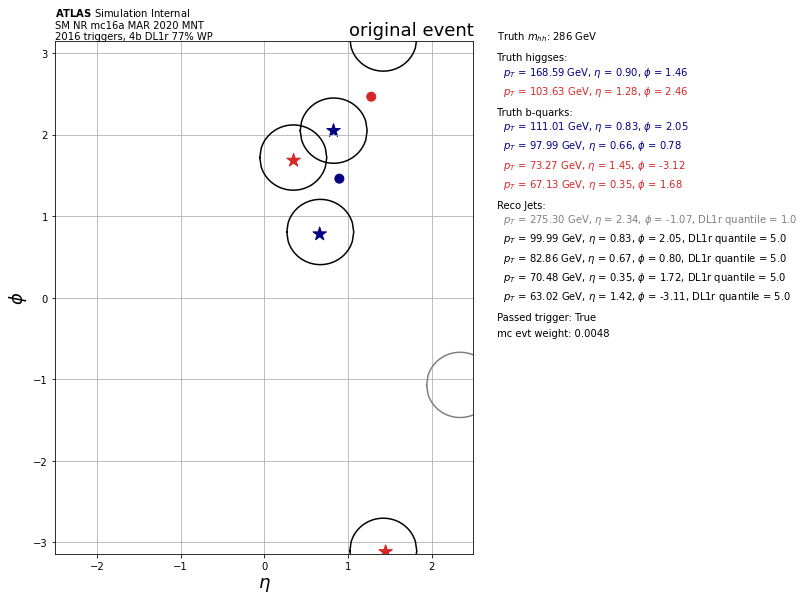

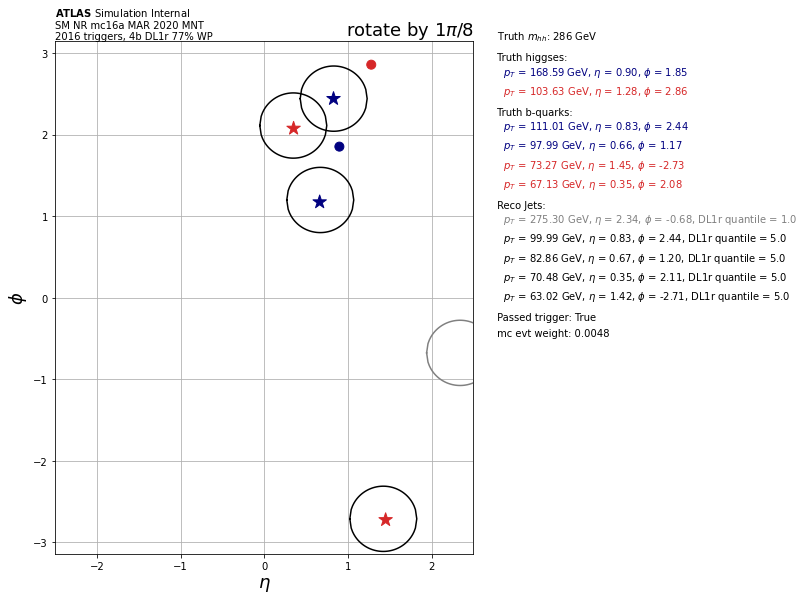

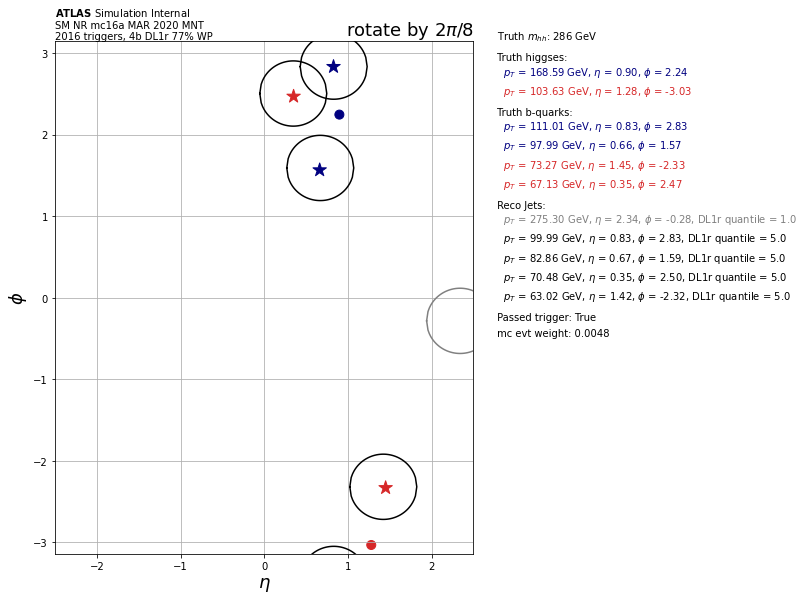

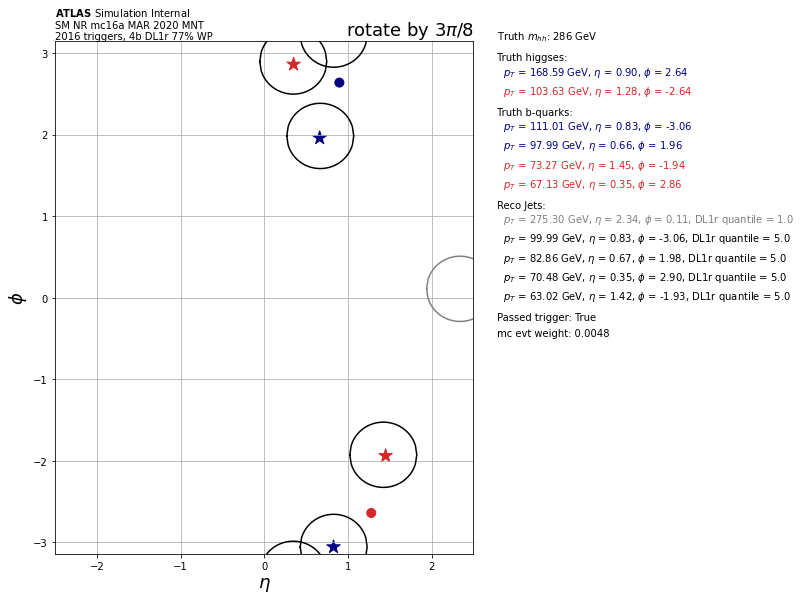

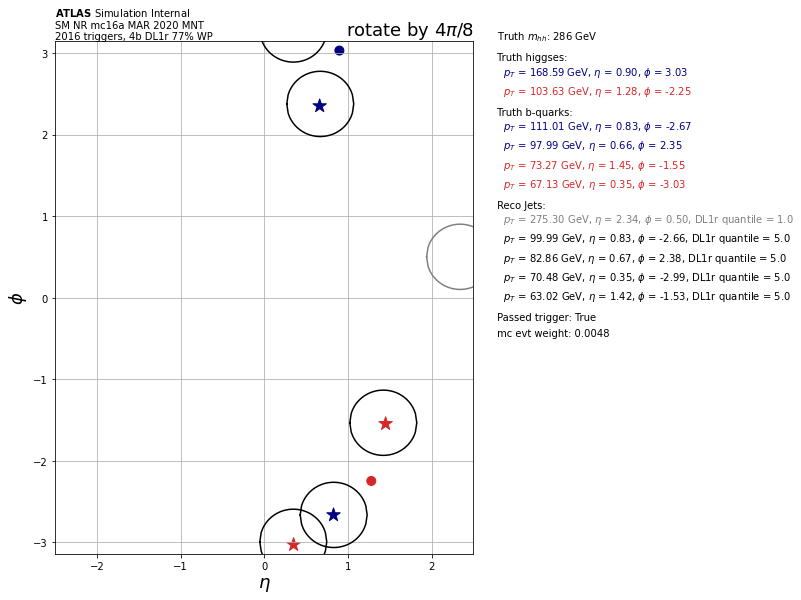

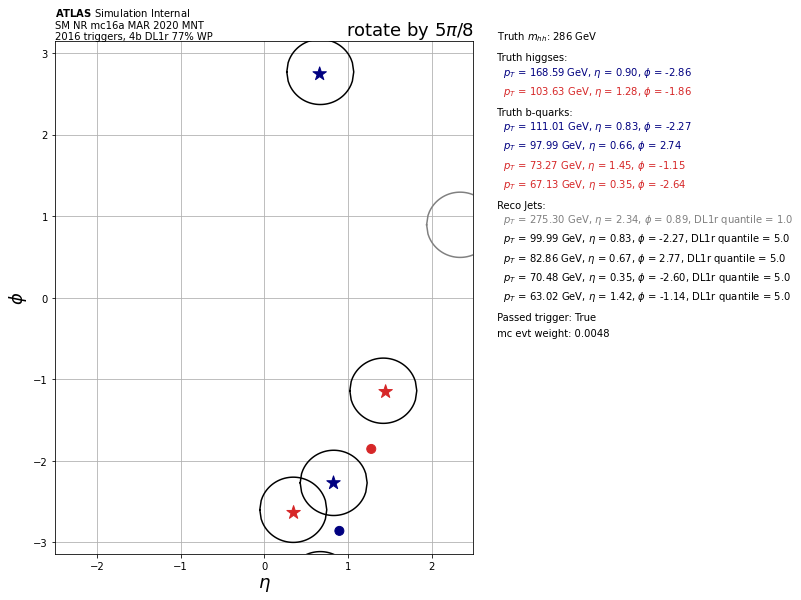

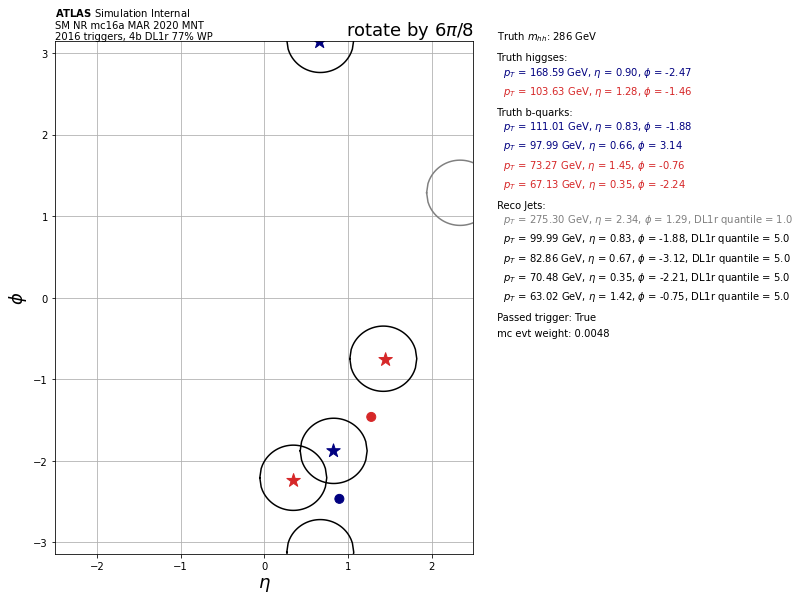

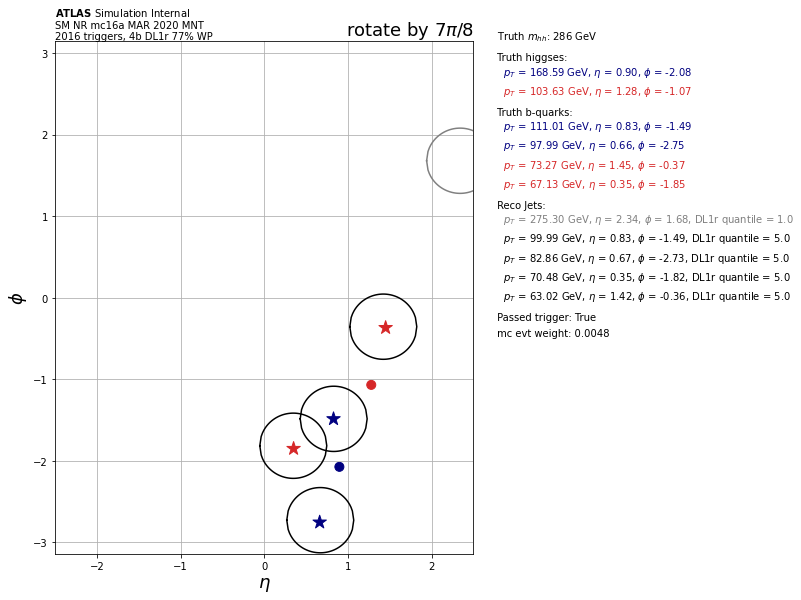

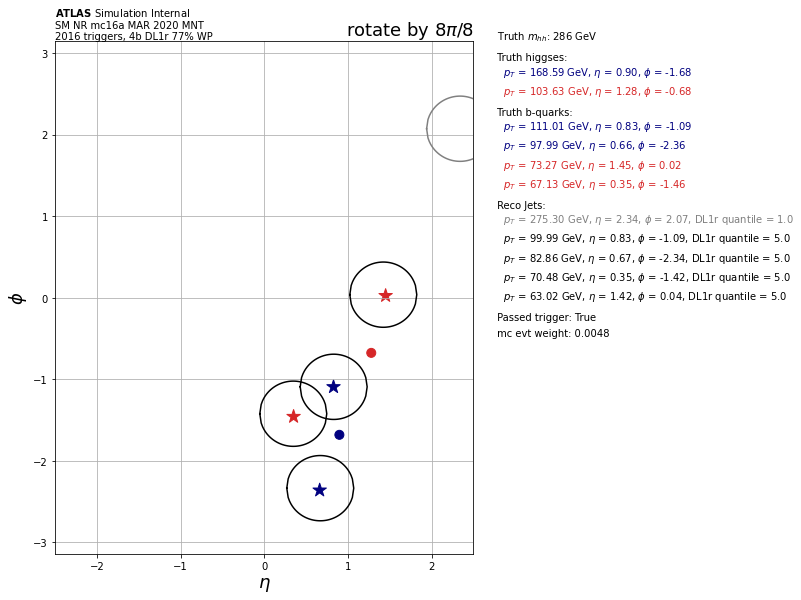

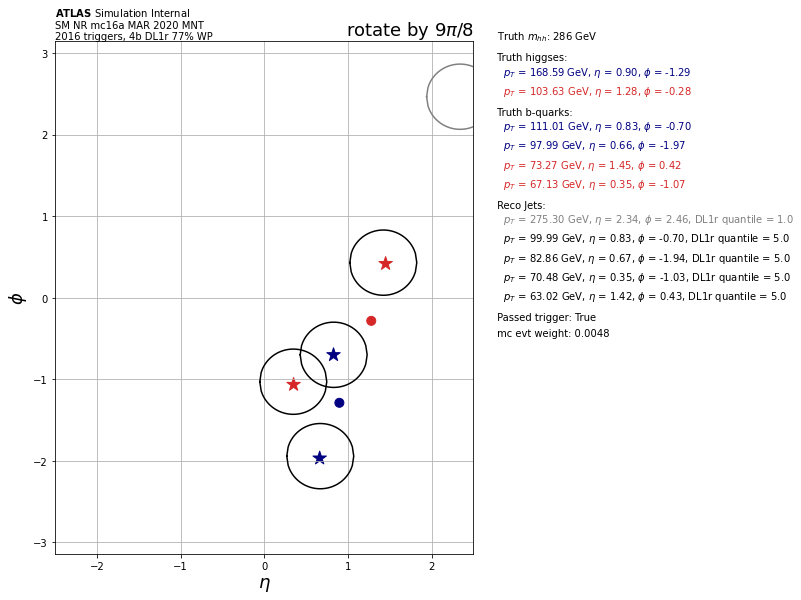

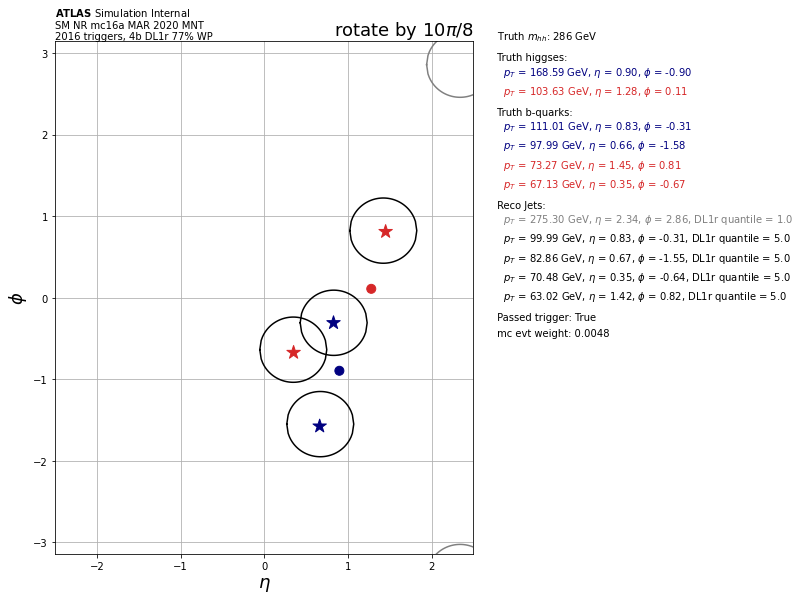

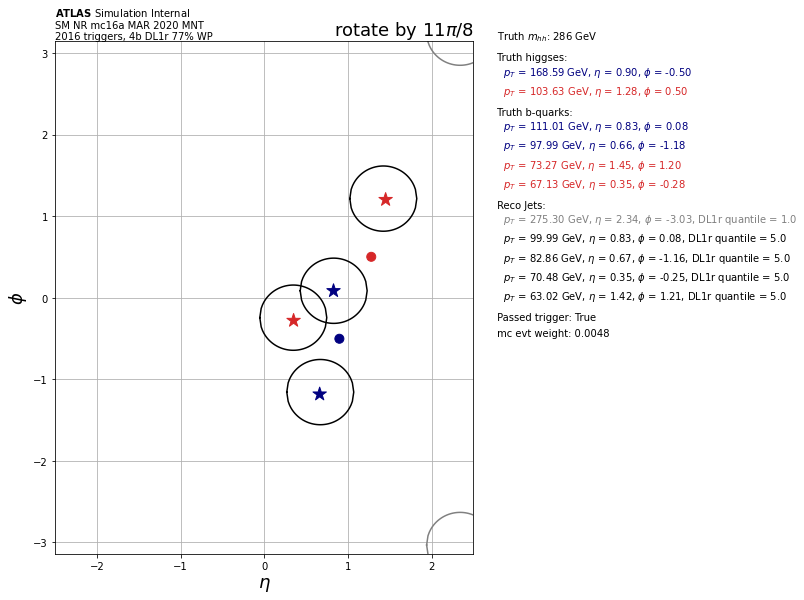

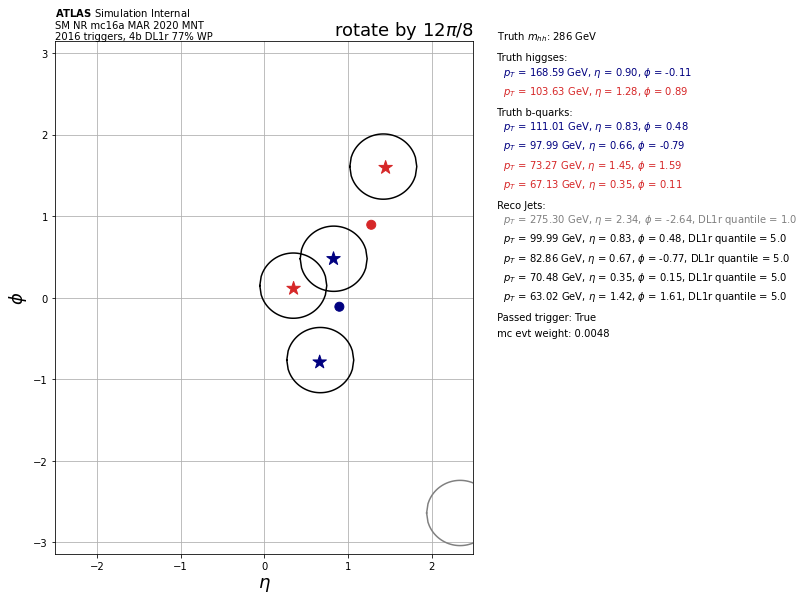

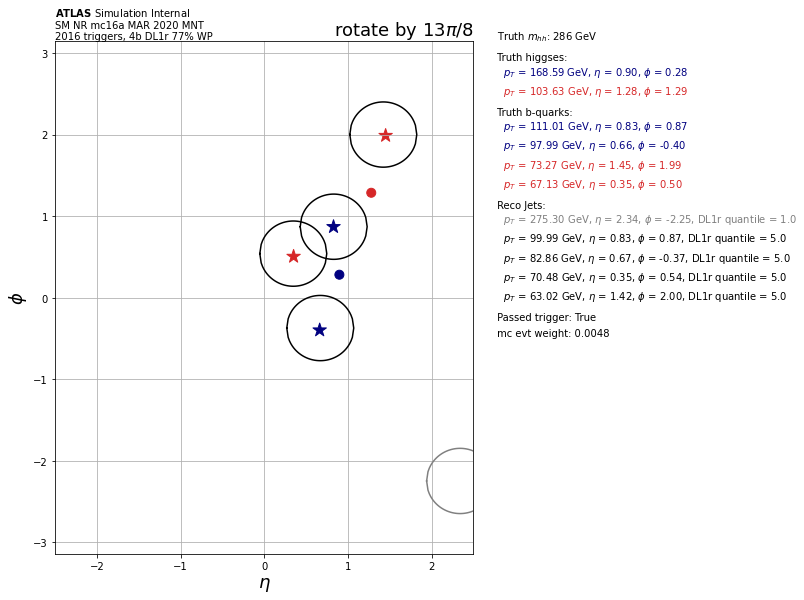

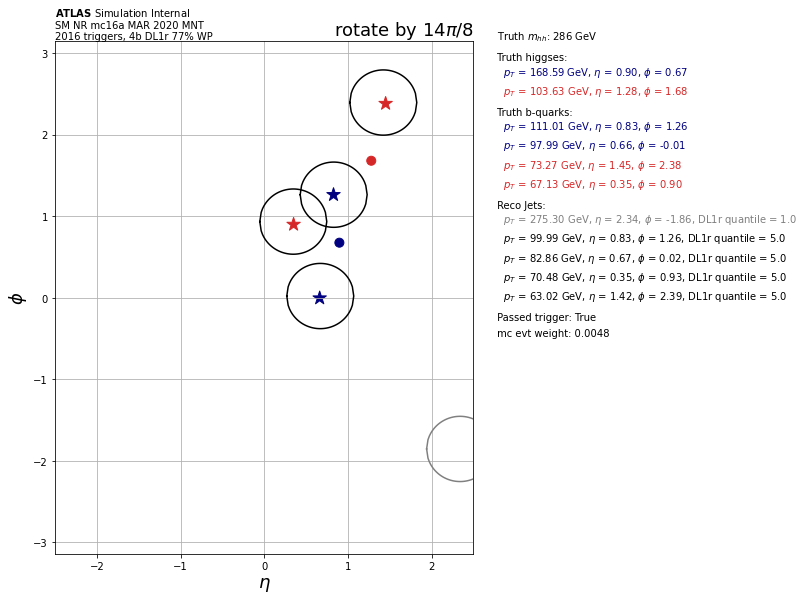

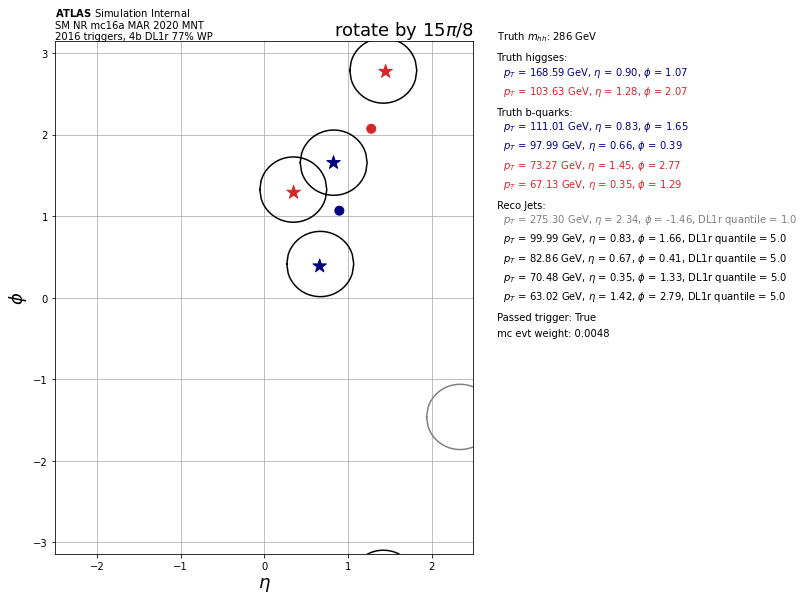

In [205]:
for ki in range(K):
    
    title='original event' if ki==0 else f'rotate by ${ki}\pi/{int(K/2)}$'
    
    tag = f'_ki{ki}' if ki != 0 else ''
    truthDisplay(ki,dfi,mode=1,nSelectedJets=nSelectedJets,
                 tagger='DL1r',text=fourbText,title=title,
                 triggerKey=True,figDir=figDir)
    #break

**Thoughts:** 
- I would *love* to have linestyles indicate which are the jets that pairAGraph chose...
- Add trigger info on this plot
- Oh - I should *color code* based on which jets paragraph selected!! Maybe I should use trasparency for the b-tagging score?

Honestly, I might want to make a new event display?

**Now evaluate pairAGraph!!**

Fortunately - since I made the decision to *not transform* $\eta$ or $\phi$ - this is pretty easy to do!!


In [206]:
# Load in the ml preprocessed inputs
jcols = [f'ml_j{i}_{v}' for i in range(nSelectedJets) for v in jetVars]
xi = df.loc[evt, jcols].values.reshape((1,nSelectedJets,len(jetVars)))

# Broadcast to allow for K events
xi = xi * np.ones((K,nSelectedJets,len(jetVars)))

# Replace phis (at index 2)
xi[:,:,2] = dfi[[f'j{i}_phi' for i in range(nSelectedJets)]]

# Make it a pytorch tensor
xi = torch.tensor(xi.astype('float')).float()

In [250]:
logits, edges = model(xi)
logp = F.log_softmax(logits, 1).detach()
p = F.softmax(logits, 1).detach()

yi = torch.max(logits,1)[1]

In [208]:
figDir

'figures/SMNR_mc16a_PFlow-MAR2020-5jets/attn_latent_1block_dim20_4heads_jetCompatibility_lr0.01_batch2048_mask/eventDisplays/event57680_rotate'

In [213]:
y_true = df.loc[evt,'correctPair']
y_true

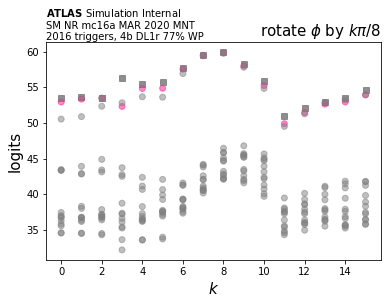

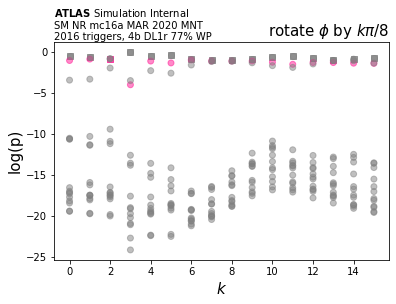

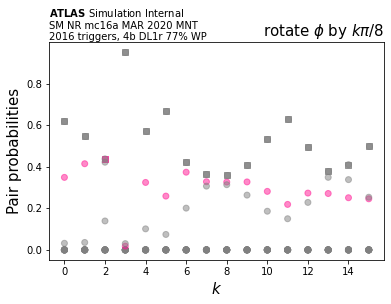

In [251]:
c='deeppink'

for s, ylabel,metric in zip([logits.detach(),logp,p],['logits','log(p)','Pair probabilities'],['logits','logp','prob']):

    plt.figure()
    plt.scatter(range(K),s[torch.arange(K),yi], marker='s', alpha=0.75,
                color=[c if yy==y_true else 'grey' for yy in yi])

    for ki in range(K):

        plt.scatter(np.ones(yi[ki])*ki,    s[ki,:yi[ki]],alpha=0.5,
                    color=[c if yy==y_true else 'grey' for yy in range(yi[ki])])
        plt.scatter(np.ones(K-yi[ki]-1)*ki,s[ki,yi[ki]:], alpha=0.5,
                    color=[c if yy==y_true else 'grey' for yy in range(yi[ki]+1,K)])

    plt.title(f'rotate $\phi$ by $k\pi/{int(K/2)}$',fontsize=15,loc='right')
    plt.xlabel('$k$',fontsize=15)
    plt.ylabel(ylabel,fontsize=15)
    
    ax = plt.gca()
    plt.text(0,1,fourbText,ha='left',va='bottom',transform=ax.transAxes)
    
    plt.savefig(f'{figDir}/{metric}.pdf',bbox_inches='tight')

    plt.show()

Would it be interesting to see if the jet selection is the same no matter *what* the azimuthal symmetry?